In [1]:
%matplotlib inline
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import datetime

import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Activation, Reshape, GlobalAveragePooling2D
from keras.models import load_model
from keras.backend.tensorflow_backend import set_session
from keras.callbacks import TensorBoard

import skimage
from skimage import io, color, transform

/opt/anaconda3/envs/dlearn/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def set_gpu_mem_alloc(mem_use):
    avail  = 4041
    percent = mem_use / avail
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = percent
    config.gpu_options.visible_device_list = "0"
    set_session(tf.Session(config=config))
    
set_gpu_mem_alloc(2700)

In [9]:
batch_size = 4
h,w,d = 224,224,3
epochs = 1000
date_str = datetime.datetime.now().strftime("%d%m%y_%H%M")

In [4]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=20, 
    shear_range=0.2,
    width_shift_range=0.1, height_shift_range=0.1,
    zoom_range=0.5                            
)


# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=20, 
    shear_range=0.2,
    width_shift_range=0.1, height_shift_range=0.1,
    zoom_range=0.5                            
)


# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'dataset/emotion/train',  # this is the target directory
        target_size=(h, w),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'dataset/emotion/valid',
        target_size=(h, w),
        batch_size=batch_size,
        class_mode='categorical')

Found 130 images belonging to 3 classes.
Found 28 images belonging to 3 classes.


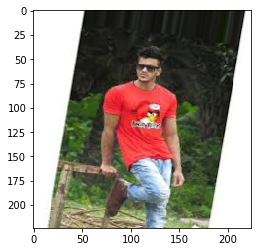

In [5]:
img = train_generator.next()[0]
plt.imshow(img[0])

In [6]:
num_class = len(train_generator.class_indices)
train_step = len(train_generator.classes)
valid_step = len(validation_generator.classes)

print('NUM Classes => ', num_class)
print('Train Step  => ',  train_step)
print('Valid Step  => ',  valid_step)

NUM Classes =>  3
Train Step  =>  130
Valid Step  =>  28


In [7]:
ksize = (3,3)
psize = (2,2)

input_shape = (h,w,d)

model = Sequential()
model.add(Conv2D(32, kernel_size=ksize, padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=psize))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=ksize, padding="same"))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=ksize, padding="same"))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=psize))
model.add(Dropout(0.25))

model.add(Conv2D(128,kernel_size=ksize, padding="same"))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128,kernel_size=ksize, padding="same"))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=psize))
model.add(Dropout(0.25))

# flatten and classifier
model.add(Flatten())
model.add(Dense(num_class))
model.add(Activation("softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
activation_2 (Activation)    (None, 112, 112, 64)      0         
__________

In [10]:
adam = keras.optimizers.Adam(lr=0.00001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [11]:
# untuk liat log history
tb1_path = 'log/'+date_str
pathlib.Path(tb1_path).mkdir(parents=True, exist_ok=True) 
#training
tensorboard = TensorBoard( log_dir=tb1_path, histogram_freq=0, 
                            write_graph=True, write_images=True)

In [12]:
model.fit_generator(
    train_generator,
    steps_per_epoch=train_step // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=valid_step // batch_size,
    callbacks=[tensorboard],
    verbose=2
)

Epoch 1/1000
 - 10s - loss: 2.4110 - acc: 0.3595 - val_loss: 1.0942 - val_acc: 0.5000
Epoch 2/1000
 - 4s - loss: 2.1819 - acc: 0.3593 - val_loss: 1.4027 - val_acc: 0.3214
Epoch 3/1000
 - 4s - loss: 1.6692 - acc: 0.4531 - val_loss: 1.4429 - val_acc: 0.4286
Epoch 4/1000
 - 4s - loss: 1.6756 - acc: 0.4841 - val_loss: 1.3978 - val_acc: 0.3929
Epoch 5/1000
 - 4s - loss: 1.6417 - acc: 0.4140 - val_loss: 1.2906 - val_acc: 0.4286
Epoch 6/1000
 - 4s - loss: 1.4536 - acc: 0.4609 - val_loss: 1.1433 - val_acc: 0.5357
Epoch 7/1000
 - 4s - loss: 1.4120 - acc: 0.4841 - val_loss: 1.3354 - val_acc: 0.5000
Epoch 8/1000
 - 4s - loss: 1.4227 - acc: 0.5156 - val_loss: 1.1409 - val_acc: 0.6429
Epoch 9/1000
 - 4s - loss: 1.2793 - acc: 0.5623 - val_loss: 1.3289 - val_acc: 0.4643
Epoch 10/1000
 - 4s - loss: 1.5488 - acc: 0.4766 - val_loss: 1.1381 - val_acc: 0.5357
Epoch 11/1000
 - 4s - loss: 1.3370 - acc: 0.5396 - val_loss: 1.5061 - val_acc: 0.5000
Epoch 12/1000
 - 4s - loss: 1.3358 - acc: 0.5547 - val_loss: 1

In [14]:
model_path = './saved/svgg'+date_str+'_'+str(epochs)+'x.h5'
model.save(model_path)

1
1
3
3


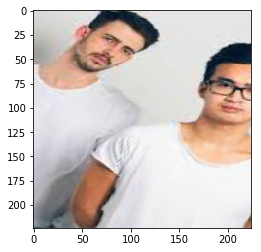

In [27]:
x, y = validation_generator.next()
img = x[0] * 255
img = img.astype("uint8")
plt.imshow(img, cmap = 'gray')

for yy in y:
    print(np.argmax(yy)+1)

In [ ]:
pred = model.predict(x)
for pr in pred:
    print(np.argmax(pr)+1)